In [1]:
from utilities.data_functions import col_to_edge_list
from utilities.vis_helpers import plot_coloring
from algorithms.color_gcn import ColorGCN
import torch
import torch.optim as optim
from utilities.eval import dot_product_loss, count_collisions

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.utils import to_dense_adj


class GraphConvolution(nn.Module):
    def __init__(self, in_features, out_features):
        super(GraphConvolution, self).__init__()
        self.W = nn.Linear(in_features, out_features)

    def forward(self, x, adj):
        out = torch.matmul(adj, x)
        out = self.W(out)
        return out


class ColorGCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout=0.5):
        super().__init__()
        self.dropout = dropout

        self.layers = nn.ModuleList()
        self.layers.append(GraphConvolution(input_dim, hidden_dim))

        for _ in range(num_layers - 2):
            self.layers.append(GraphConvolution(hidden_dim, hidden_dim))

        self.get_color = nn.Sequential(
            nn.Linear(hidden_dim, output_dim),
            nn.Softmax(dim=1)
        )

        self.adj_normalized = None

    def forward(self, x, edge_index):
        if self.adj_normalized is None:
            self._make_adj(edge_index)

        for i, layer in enumerate(self.layers):
            x = layer(x, self.adj_normalized)
            # Apply activation and dropout for all layers except the last one
            if i < len(self.layers) - 1:
                x = F.relu(x)
                x = F.dropout(x, p=self.dropout, training=self.training)
            self.get_color(x)
        return x

    def _make_adj(self, edge_index):
        # Create the adjacency matrix from an edge index
        adj = to_dense_adj(edge_index).squeeze(0)

        # Add self-loops and normalize the adjacency matrix
        # adj = adj + torch.eye(adj.size(0)).to(adj.device)
        # D = torch.diag(torch.sum(adj, dim=1) ** (-0.5))
        # self.adj_normalized = torch.matmul(torch.matmul(D, adj), D)
        self.adj_normalized = adj


In [ ]:
# Load and plot the graph

graph = 'anna.col'
n, edge_list, col_list = col_to_edge_list(f'data/input/COLOR/instances/{graph}')
plot_coloring(edge_list)

In [11]:
# Run the graph model
input_dim = 43
hidden_dim = 22
output_dim = 11
num_layers = 2
epochs = 10000

model = ColorGCN(input_dim, hidden_dim, output_dim, num_layers, dropout=0.1)
graph_rep = torch.randn((n, input_dim))
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for i in range(epochs):
    model.train()
    optimizer.zero_grad()
    out = model(graph_rep, edge_list)
    loss = dot_product_loss(out, edge_list)
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        model.eval()
        with torch.no_grad():
            out = model(graph_rep, edge_list)
        coloring = torch.argmax(out, dim=1)
        print(f'{i}: {count_collisions(coloring, edge_list)}')
        # print(f'{i}: {loss}')



0: 218
100: 52
200: 42
300: 58
400: 60
500: 58
600: 66
700: 60
800: 74
900: 76
1000: 66
1100: 66
1200: 72
1300: 74
1400: 74
1500: 72
1600: 74
1700: 74
1800: 70
1900: 76
2000: 76
2100: 76
2200: 78
2300: 72
2400: 72
2500: 62
2600: 68
2700: 68
2800: 68
2900: 68
3000: 72
3100: 72
3200: 72
3300: 72
3400: 74
3500: 72
3600: 72
3700: 72
3800: 70
3900: 70
4000: 70
4100: 74
4200: 74
4300: 74
4400: 74
4500: 72
4600: 72
4700: 72
4800: 72
4900: 72
5000: 72
5100: 74
5200: 74
5300: 74
5400: 74
5500: 74
5600: 72
5700: 70
5800: 70
5900: 70
6000: 70
6100: 70
6200: 70
6300: 70
6400: 70
6500: 70
6600: 70
6700: 70
6800: 70
6900: 70
7000: 70
7100: 70
7200: 70
7300: 70
7400: 70
7500: 70
7600: 70
7700: 70
7800: 70
7900: 70
8000: 70
8100: 70
8200: 70
8300: 70
8400: 70
8500: 70
8600: 70
8700: 70
8800: 70
8900: 70
9000: 70
9100: 70
9200: 70
9300: 70
9400: 72
9500: 72
9600: 72
9700: 72
9800: 72
9900: 72


In [12]:
model

ColorGCN(
  (layers): ModuleList(
    (0): GraphConvolution(
      (W): Linear(in_features=43, out_features=22, bias=True)
    )
  )
  (get_color): Sequential(
    (0): Linear(in_features=22, out_features=11, bias=True)
    (1): Softmax(dim=1)
  )
)

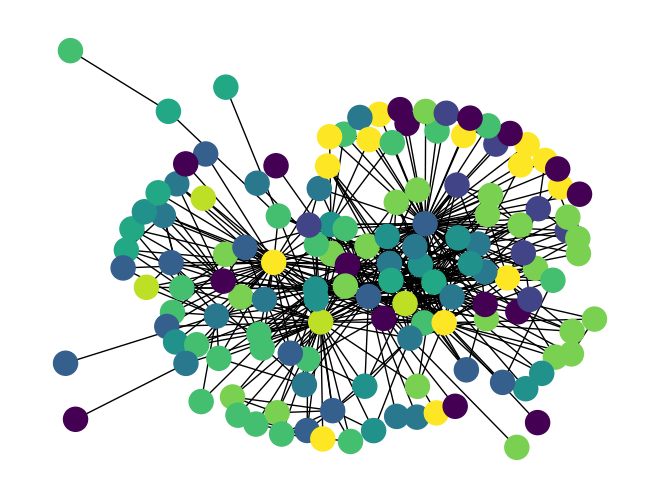

In [5]:
# Plot the colored graph

plot_coloring(edge_list, coloring)


In [19]:
torch.sum(to_dense_adj(edge_list).squeeze(0).T - to_dense_adj(edge_list).squeeze(0))

tensor(0.)

In [16]:
torch.sum(model.adj_normalized - model.adj_normalized.T)

tensor(0.)